## Images

In [2]:
import torch
import numpy as np
from PIL import Image
from torchvision import transforms
import os, random
# Load the image
base_dir = '/data/valerii/gan_adversarial/data/test_set/test_set/cats/'
filenames = os.listdir(base_dir)
transform = transforms.ToTensor()

# image_path = random.choice(filenames)
width, height = [], []

for filename in filenames:
    if filename[-3:] == 'jpg':
        image = Image.open(base_dir+filename)
        tensor_image = transform(image)
        resolution = tensor_image.shape[1], tensor_image.shape[2]
        width.append(tensor_image.shape[1])
        height.append(tensor_image.shape[2])

ModuleNotFoundError: No module named 'torchvision'

Выборка сбалансированная: в выборках 50% собак и 50% кошек

In [9]:
import os
def count_files_in_directory(directory):
    total_files = 0
    for root, dirs, files in os.walk(directory):
        total_files += len(files)
    return total_files
print('training set size:', count_files_in_directory('./data/training_set'))
print('test set size:', count_files_in_directory('./data/test_set'))

training set size: 8007
test set size: 2025


In [12]:
base_dir = './data'
from utils.MakeDataset import MakeDataset
train_dataset = MakeDataset(base_dir, 'training_set')
test_dataset = MakeDataset(base_dir, 'test_set')

get dataset from ./data/test_set/dogs/...: 100%|██████████| 200/200 [00:00<00:00, 270.27it/s]


In [13]:
len(train_dataset)

400

In [24]:
print(f'width: {np.mean(width)}, +-{2*np.std(width)}, height: {np.mean(height)} +- {2*np.std(height)}')

width: 356.27299703264094, +-191.69342335392557, height: 412.6656775469832 +- 214.67062617156938


## Classifier

В качестве основного классификатора, предсказания которого и планируется испортить, используется ResNet18

In [4]:
import torch
import torch.nn as nn
import torchvision.models as models


In [15]:
resnet18=models.resnet18(pretrained=True)
num_params = sum(p.numel() for p in resnet18.parameters())
print(f"Number of parameters in the model: {num_params}, with weight of {'{:.2f}'.format(num_params*4/1024/1024)} MB")

Number of parameters in the model: 11689512, with weight of 44.59 MB


In [2]:
from Classifier import ResNet18
model=ResNet18()



/home/stud_valery/anaconda3/envs/torchenv/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/stud_valery/anaconda3/envs/torchenv/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


## Dataset Class

In [23]:
from utils.MakeDataset import MakeDataset
import random
base_dir='./data'

dataset = MakeDataset(base_dir, 'test_set')

get dataset from ./data/test_set/dogs/...: 100%|██████████| 200/200 [00:00<00:00, 264.00it/s]


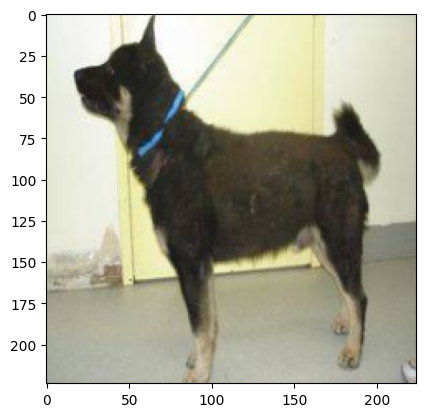

In [26]:
dataset.show_tensor_image(random.choice(dataset)[0])

## Generator

In [1]:
from Generator import GeneratorVAE
from MakeDataset import MakeDataset
base_dir='/home/stud_valery/gan_adversarial/data'

gen = GeneratorVAE()
dataset = MakeDataset(base_dir, 'test_set', limit=100)

get dataset from /home/stud_valery/gan_adversarial/data/test_set/cats/...: 100%|██████████| 100/100 [00:00<00:00, 261.21it/s]
get dataset from /home/stud_valery/gan_adversarial/data/test_set/dogs/...: 100%|██████████| 100/100 [00:00<00:00, 250.64it/s]


In [3]:
import numpy as np
pixel_sums = []
for i in range(len(dataset)):
    pixel_sums.append(dataset[i][0].sum())
print(np.mean(pixel_sums), np.std(pixel_sums))

6779.435 66506.24


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


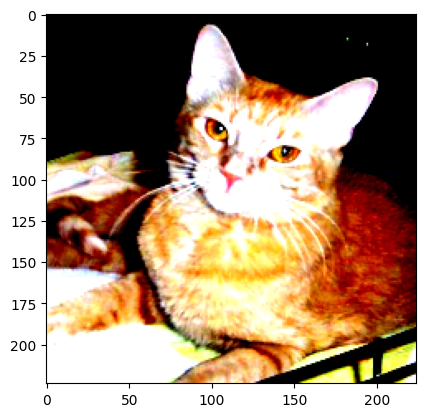

In [17]:
dataset.show_tensor_image(dataset[3][0])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


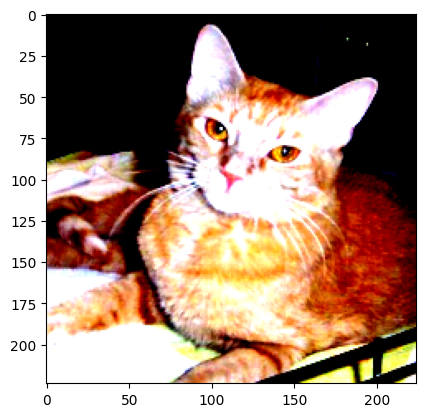

In [21]:
dataset.show_tensor_image(dataset[3][0] + out[0].detach().cpu())

In [10]:
import torch
target_sum = 50
current_sum = torch.sum(out[0])
normalized_image = (out[0] / current_sum) * target_sum

In [13]:
normalized_image.sum()

tensor(50., grad_fn=<SumBackward0>)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


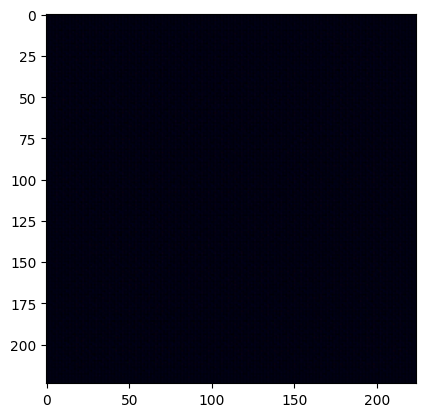

In [9]:
dataset.show_tensor_image(out[0].detach().cpu())

## Evaluate Resnet18

In [15]:
from utils.Evaluater import Evaluater
from Classifiers.ResNet18 import ResNet18
from utils.MakeDataset import MakeDataset
from torch.utils.data import DataLoader
import torch

base_dir='./data'
dataset = MakeDataset(base_dir, 'test_set')
dataloader = DataLoader(dataset, batch_size=30, shuffle=False)

model = ResNet18()
params = torch.load('./train_record/resnet18/best_model',\
                     map_location='cuda:'+str(0))
model.load_state_dict(params)


evaluater = Evaluater(model, dataloader, 0)
evaluater.eval()

Evaluating...: 100%|██████████| 68/68 [00:07<00:00,  9.07it/s]


{'f1': 0.9332595467567444,
 'accuracy': 0.9332674145698547,
 'precision': 0.9334579706192017,
 'recall': 0.9332622289657593}

dog


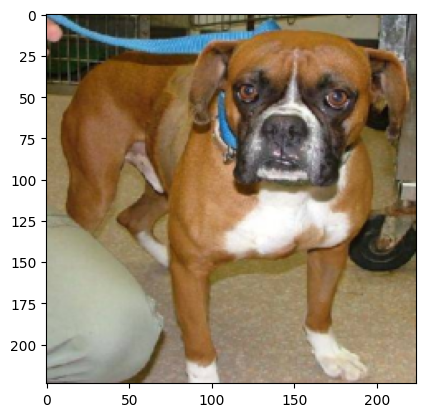

In [64]:
import random

img, target = random.choice(dataset)
predict = model(img.to(0).unsqueeze(0))
print("dog" if predict > 0.5 else "cat")
dataset.show_tensor_image(img)

## Check attacked FGSM classifier performance

In [1]:
from NoiseGen.Generator import *
from Classifiers.FGSMClassifier import FGSMClassifier
from torch.utils.data import DataLoader
from utils.Evaluater import Evaluater
from Classifiers.ResNet18 import ResNet18
from utils.MakeDataset import MakeDataset
from torch.utils.data import DataLoader
import torch

device = 0

base_dir='./data'
dataset = MakeDataset(base_dir, 'test_set', limit=100)
dataloader = DataLoader(dataset, batch_size=30, shuffle=False)

# attacker = GeneratorVAE().to(device)
# gen_params = torch.load('./train_record/gan_vae_img/params/last_epoch.pt',\
#                      map_location='cuda:'+str(device))
# attacker.load_state_dict(gen_params)

classifier = ResNet18().to(device)
params = torch.load('./train_record/resnet18/best_model',\
                     map_location='cuda:'+str(device))
classifier.load_state_dict(params)

/home/olisvalue/torchenv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
get dataset from ./data/test_set/dogs/...: 100%|██████████| 100/100 [00:00<00:00, 827278.90it/s]
/home/olisvalue/torchenv/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/olisvalue/torchenv/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.war

<All keys matched successfully>

In [10]:
evaluater = Evaluater(classifier, dataloader, device)
evaluater.eval()

Evaluating...: 100%|██████████| 7/7 [00:00<00:00,  9.70it/s]


{'f1': 0.934959352016449,
 'accuracy': 0.9350000023841858,
 'precision': 0.9360902309417725,
 'recall': 0.9350000023841858}

In [16]:
attacked_classifier = FGSMClassifier(classifier,eps = 0.025).to(device)
evaluater = Evaluater(attacked_classifier, dataloader, device)
evaluater.eval()

Evaluating...: 100%|██████████| 68/68 [00:13<00:00,  4.89it/s]


{'f1': 0.5553352236747742,
 'accuracy': 0.5580820441246033,
 'precision': 0.5596030950546265,
 'recall': 0.5581210255622864}

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


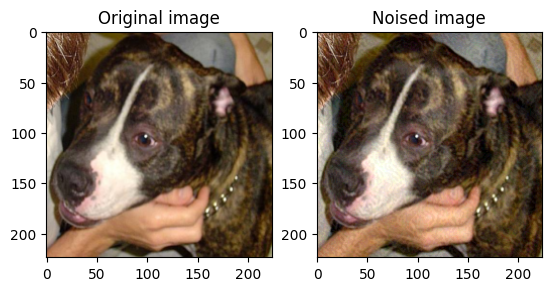

non-attacked classifier: dog
attacked classifier: dog


In [23]:
import random
classifier.eval()
img, target = random.choice(dataset)
classifier_predict = classifier(img.to(device).unsqueeze(0))
attacked_classifier_predict = attacked_classifier(img.to(device).unsqueeze(0), draw_mode=True)

def print_predict(predict, text):
    print(text + "dog" if predict > 0.5 else text + "cat") 
# print(classifier_predict)
# print(attacked_classifier_predict)
print_predict(classifier_predict, "non-attacked classifier: ")
print_predict(attacked_classifier_predict, "attacked classifier: ")

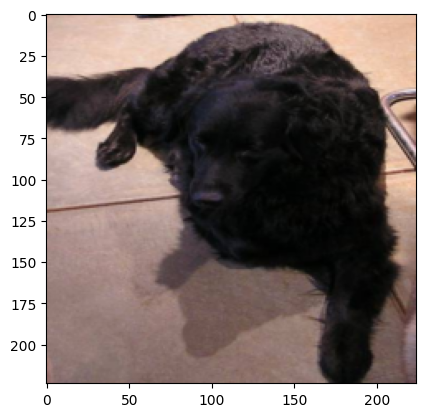

In [16]:
dataset.show_tensor_image(img)

## Check generated gradient attack performance

In [29]:
from NoiseGen.Generator import *
from torch.utils.data import DataLoader
from utils.Evaluater import Evaluater
from Classifiers.ResNet18 import ResNet18
from Classifiers.GenGradAttacked import GenGradAttacked
from utils.MakeDataset import MakeDataset
from torch.utils.data import DataLoader
import torch

device = 0

base_dir='./data'
dataset = MakeDataset(base_dir, 'test_set')
dataloader = DataLoader(dataset, batch_size=30, shuffle=False)

gradgenerator = GeneratorVAE().to(device)

classifier = ResNet18().to(device)
params = torch.load('./train_record/resnet18/best_model',\
                     map_location='cuda:'+str(device))
classifier.load_state_dict(params)

attacked_classifier = GenGradAttacked(gradgenerator, classifier, eps = 0.007).to(device)
attacked_classifier.eval()
None


get dataset from ./data/test_set/dogs/...: 100%|██████████| 1013/1013 [00:00<00:00, 959103.83it/s]


In [10]:
evaluater = Evaluater(classifier, dataloader, device)
evaluater.eval()

Evaluating...: 100%|██████████| 68/68 [00:07<00:00,  9.33it/s]


{'f1': 0.9332595467567444,
 'accuracy': 0.9332674145698547,
 'precision': 0.9334579706192017,
 'recall': 0.9332622289657593}

In [30]:
evaluater = Evaluater(attacked_classifier, dataloader, device)
evaluater.eval()

Evaluating...: 100%|██████████| 68/68 [00:08<00:00,  8.03it/s]


{'f1': 0.9332609176635742,
 'accuracy': 0.9332674145698547,
 'precision': 0.9334237575531006,
 'recall': 0.9332627654075623}

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


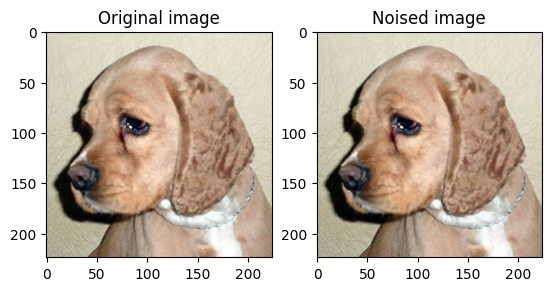

tensor([1], device='cuda:0')
tensor([1], device='cuda:0')
non-attacked classifier: dog
attacked classifier: dog


In [33]:
import random

img, target = random.choice(dataset)
classifier_predict = classifier(img.to(device).unsqueeze(0))
attacked_classifier_predict = attacked_classifier(img.to(device).unsqueeze(0), draw_mode=True)

def print_predict(predict, text):
    print(text + "dog" if predict > 0.5 else text+"cat") 
print(classifier_predict)
print(attacked_classifier_predict)
print_predict(classifier_predict, "non-attacked classifier: ")
print_predict(attacked_classifier_predict, "attacked classifier: ")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


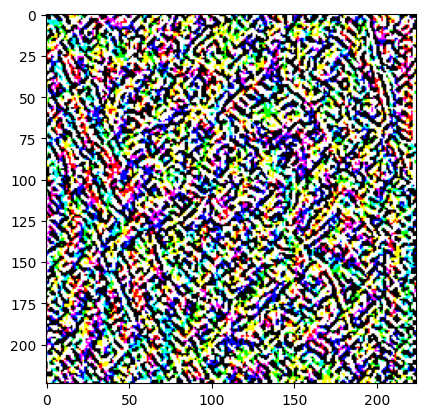

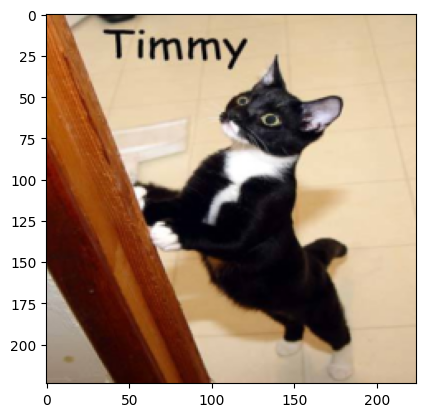

tensor([0], device='cuda:0')
tensor([1], device='cuda:0') tensor([1], device='cuda:0')


In [34]:
from torch.nn import functional as nnf
import random
import torch

classifier.train()

eps = 0.050

img, target = random.choice(dataset)
sample = img.to(device).unsqueeze(0)
target = torch.tensor(target).to(device).unsqueeze(0)
sample.requires_grad = True

output = classifier(sample)
classifier.zero_grad()

cost = nnf.cross_entropy(output, target).to(device)
cost.backward()

attack_sample = sample + eps*sample.grad.sign()
attack_sample = torch.clamp(attack_sample, 0, 1)

dataset.show_tensor_image(sample.grad.sign().cpu().detach().squeeze(0))
dataset.show_tensor_image(img)

classifier.zero_grad()

# target_grad = sample.grad.sign()
sample = torch.clamp(sample, 0, 1)
# classifier.eval()
print(target)

classifier.eval()
print(classifier(attack_sample), classifier(sample))
